In [1]:
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import Imputer

import diff_classifier.aws as aws
import pandas as pd
import numpy as np
import mpl_toolkits.mplot3d.axes3d as p3

from sklearn import cluster, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

In [6]:
rfol = '01_18_Experiment/P3'
counter = 0
to_merge = []

for i in range(0, 15):
    n = '{}'.format(i)
    n = n.zfill(4)

    features = 'features_P3_S1_R_{}'.format(n)
    rfile = '{}/{}.csv'.format(rfol, features)
    lfile = '{}.csv'.format(features)

    aws.download_s3(rfile, lfile, bucket_name='ccurtis.data')
    to_merge.append(pd.read_csv(lfile, sep=",", index_col='Unnamed: 0'))

features = pd.concat(to_merge)
features = features.reset_index()
features = features.drop(columns=['index'])
features = features.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
features = features[features['frames'] > 40]

In [7]:
f2 = features[['AR', 'D_fit', 'MSD_ratio', 'alpha', 'asymmetry1']]

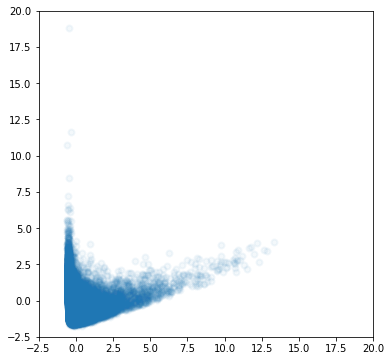

In [8]:
pca = PCA(n_components=2)
f2_r = pca.fit(f2).transform(f2)

scaler = StandardScaler()
delete = f2_r[:, 0].argsort()[-12:]
for i in delete:
    f2_r[i, :] = [np.nan, np.nan]
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
imp.fit(f2_r)
f2_r = imp.transform(f2_r)
test = scaler.fit_transform(f2_r)

lw = 2
plt.figure(figsize=(6, 6))
plt.scatter(test[:, 0], test[:, 1], alpha=0.05, lw=lw)
plt.xlim([-2.5, 20])
plt.ylim([-2.5, 20])
plt.show()

In [9]:
features['param1'] = pd.Series(test[:, 0], index = features.index)
features['param2'] = pd.Series(test[:, 1], index = features.index)

In [10]:
import time
import warnings

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3}

num = 12
t0 = time.time()

birch = cluster.Birch(n_clusters=num)
name = "Birch"
algorithm = birch

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="the number of connected components of the", category=UserWarning)
    warnings.filterwarnings("ignore", message="Graph is not fully connected spectral embedding", category=UserWarning)
    algorithm.fit(test)


if hasattr(algorithm, 'labels_'):
    y_pred = algorithm.labels_.astype(np.int)
else:
    y_pred = algorithm.predict(test)

6.488752126693726 seconds


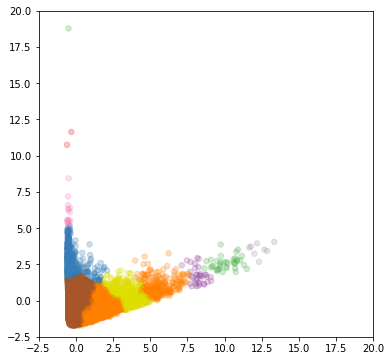

In [11]:
plt.figure(figsize=(6, 6))
colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                     '#f781bf', '#a65628', '#984ea3',
                                     '#999999', '#e41a1c', '#dede00']),
                              int(max(y_pred) + 1))))
plt.scatter(test[:, 0], test[:, 1], s=30, color=colors[y_pred], alpha=0.25)

plt.xlim(-2.5, 20)
plt.ylim(-2.5, 20)
t1 = time.time()   
print("{} seconds".format(t1-t0))

plt.show()

In [12]:
features['cluster'] = pd.Series(y_pred, index = features.index)

In [13]:
difference = features['Track_ID'][1:].as_matrix() - features['Track_ID'][:-1].as_matrix()

In [14]:
split = difference.argsort()[0:14]

In [15]:
split = split[split.argsort()]

In [16]:
split

array([ 1010,  4196,  8396, 11757, 12458, 14078, 15672, 18925, 25209,
       27539, 29181, 29302, 29821, 30158])

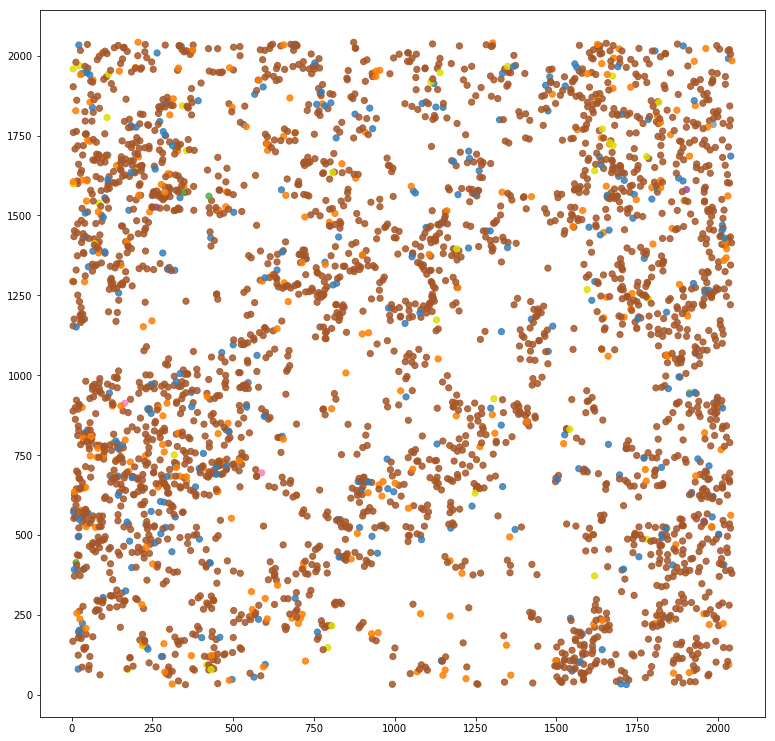

In [17]:
i=7
if i == 0:
    lo = 0
else:
    lo = split[i-1]+1
hi = split[i]
plt.figure(figsize= (13, 13))
plt.scatter(features['X'][lo:hi], features['Y'][lo:hi], s=38, color=colors[features['cluster']], alpha=0.85)
plt.show()

In [18]:
for i in range(0, 12):
    n1 = features[features['cluster']==i].shape[0]
    print("Cluster {} has {} trajectories".format(i, n1))

Cluster 0 has 2179 trajectories
Cluster 1 has 226 trajectories
Cluster 2 has 37 trajectories
Cluster 3 has 16 trajectories
Cluster 4 has 25534 trajectories
Cluster 5 has 35 trajectories
Cluster 6 has 8 trajectories
Cluster 7 has 2 trajectories
Cluster 8 has 480 trajectories
Cluster 9 has 1 trajectories
Cluster 10 has 3031 trajectories
Cluster 11 has 1 trajectories


In [19]:
features[features['cluster']==0].head()

,AR,D_fit,MSD_ratio,Track_ID,X,Y,alpha,asymmetry1,asymmetry2,asymmetry3,...,efficiency,elongation,fractal_dim,frames,kurtosis,straightness,trappedness,param1,param2,cluster
0,4.843216,0.017095,-0.003607,0.0,109.825540,1685.955701,1.988511,0.998416,0.019909,0.619378,...,8.613752,0.793526,1.427955,487.0,2.240154,0.151889,-0.227134,-0.498749,3.082315,0
85,3.023343,0.001133,-0.011087,85.0,327.903756,1794.445484,2.656446,0.939213,0.125208,0.359842,...,2.972916,0.669240,1.492418,114.0,3.891162,0.184573,-0.225728,-0.501309,1.656590,0
113,3.883780,0.147555,-0.002025,113.0,730.412288,1802.216443,1.383002,0.994549,0.036967,0.564302,...,2.816215,0.742519,1.637434,651.0,1.583364,0.074276,-0.227000,-0.462737,1.772174,0
115,3.873962,0.180560,-0.007899,115.0,674.960991,1571.519083,1.659955,0.989528,0.051302,0.522840,...,7.222149,0.741866,1.409882,220.0,1.722711,0.206477,-0.226894,-0.459901,1.929371,0
119,4.105776,2.173764,-0.003049,119.0,802.544984,1588.835184,1.115011,0.997155,0.026689,0.596675,...,3.979204,0.756441,1.498454,493.0,1.458257,0.101488,-0.227085,-0.083910,1.965311,0


In [20]:
features[features['cluster']==4].head()

,AR,D_fit,MSD_ratio,Track_ID,X,Y,alpha,asymmetry1,asymmetry2,asymmetry3,...,efficiency,elongation,fractal_dim,frames,kurtosis,straightness,trappedness,param1,param2,cluster
1,3.488764,0.134011,-0.001871,1.0,370.709952,1790.691112,1.434573,0.993296,0.041009,0.552198,...,2.621121,0.713366,1.627439,651.0,2.368872,0.072523,-0.226996,-0.464050,1.408634,4
2,1.892945,1.820750,0.019851,2.0,269.304877,1554.225506,0.679904,0.771275,0.254630,0.194161,...,0.683550,0.471723,1.717935,72.0,2.479656,0.110128,-0.222406,-0.133755,-0.570963,4
3,1.885875,0.015653,0.004799,3.0,266.103032,1901.662800,1.454997,0.762498,0.260164,0.189153,...,0.384158,0.469742,1.813517,651.0,3.829716,0.027630,-0.226628,-0.478606,-0.233208,4
4,1.406256,0.729116,-0.000671,4.0,439.967752,1620.262535,1.023416,0.681250,0.309295,0.149834,...,0.884269,0.288892,1.806886,141.0,1.855031,0.091362,-0.223971,-0.338460,-0.940365,4
5,2.384414,0.049828,-0.003278,5.0,63.756549,1661.150485,1.619858,0.959893,0.101158,0.405188,...,2.042836,0.580610,1.568110,321.0,1.901472,0.090900,-0.226758,-0.476792,0.407360,4
